In [1]:
import os

In [2]:
from langgraph.graph import StateGraph
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

import operator

from pydantic import BaseModel, Field

In [4]:
from typing import Annotated, Optional, Sequence, List, Literal

In [38]:
from prompts import transform_messages_into_research_topic_prompt, clarify_with_user_instructions

## Define States

In [5]:
class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from the user input"""
    pass

In [6]:
class AgentState(MessagesState):
    """Main state for the full agent research system
    
    We have additional fields for research coordination"""

    research_brief: Optional[str]
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    raw_notes: Annotated[list[str], operator.add] = []
    notes: Annotated[list[str], operator.add] = []
    final_report: str


## Structured Output Schemas

In [7]:
class ClarifyWithUser(BaseModel):
    """Schema for clarification decision and question"""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying questions")
    
    question: str = Field(
        description="A question to ask the user to clarify the report scope")
     
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )
    


In [8]:
class ResearchQuestion(BaseModel):
    """Schema for structured research brief generation"""
    research_brief: str = Field(
        description="A research question that would be used to guide the research"
    )

In [9]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

In [11]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

# from langchain_openai import ChatOpenAI
# openai_model = ChatOpenAI(model= 'gpt-4o', temperature=0.0)

from langchain_groq import ChatGroq

model = ChatGroq(model='llama-3.3-70b-versatile', 
                 api_key=os.environ.get("GROQ_API_KEY"),
                 temperature=0.0)

## Start working on clarification node and reseach brief

In [12]:
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string

from langgraph.graph import StateGraph, START, END

from langgraph.types import Command, Interrupt

input - > check clarifying question -yes.  -> ask question
                                    - no   -> generate brief

In [18]:
from datetime import datetime

In [19]:
def get_today_str()->str:
    return datetime.now().strftime("%a %b %-d, %Y")

In [ ]:
def clarify_with_user(state: AgentInputState) ->Command[Literal["write_research_brief","__end__"]]:
    

    structured_llm = model.with_structured_output(ClarifyWithUser)

    prompt_ = clarify_with_user_instructions.format(messages=get_buffer_string(state['messages']), date=get_today_str())
    response = structured_llm.invoke([HumanMessage(content=prompt_)])

    if response.need_clarification:
        return Command(goto=END,
                       update={"messages":[AIMessage(content=response.question)]})
    
    else:
        return Command(
            goto="write_research_brief",
            update={"messages":[AIMessage(content=response.verification)]}
        )


    

In [21]:
prompt_transform_message_into_research_topic="""
Your are helpful assistant tasked with transforming a raw messages into a research brief.

Your job is to translate these messages into a more detailed and concrete research question \
that will guide the research.

The messages exchanged between yourself and the user:
<messages>
{messages}
</messages>

Today's date is {date}.

You will return a single research question that will be used to guide the research."""

In [ ]:
def write_research_brief(state:AgentState):
    """
    Transform the conversation history into a comprehensive research brief"""

    structured_output_model = model.with_structured_output(ResearchQuestion)

    _prompt = prompt_transform_message_into_research_topic.format(messages = get_buffer_string(state.get("messages",[])),
                                                                                              date=get_today_str()
                                                                )
    response = structured_output_model.invoke([HumanMessage(content=_prompt)])

    return {
        "research_brief":response.research_brief,
        "supervisor_messages":[HumanMessage(content=f"{response.research_brief}.")]
    }

## Graph Construction

In [30]:
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

scope_research = deep_researcher_builder.compile()

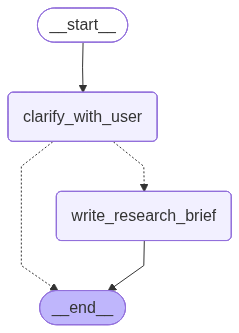

In [31]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [32]:
# Run the workflow
from utils import format_messages
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ What specific aspects of the coffee shops in San Francisco are you looking to research, such as their location, │
│ price range, or type of coffee?                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [33]:
result = scope.invoke({"messages": [HumanMessage(content="Let's examine coffee quality to assess the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ What specific aspects of the coffee shops in San Francisco are you looking to research, such as their location, │
│ price range, or type of coffee?                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine coffee quality to assess the best coffee shops in San Francisco.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ What factors contribute to coffee quality for you, such as taste, freshness, roast level, or sourcing methods?  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [34]:
result = scope.invoke({"messages": [HumanMessage(content="Let's use flavor profile to judge the.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ What specific aspects of the coffee shops in San Francisco are you looking to research, such as their location, │
│ price range, or type of coffee?                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine coffee quality to assess the best coffee shops in San Francisco.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ What factors contribute to coffee quality for you, such as taste, freshness, roast level, or sourcing methods?  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's use flavor profile to judge the.                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Are you looking for a specific flavor profile, such as fruity, nutty, or chocolatey, or do you want to consider │
│ a wide range of flavor profiles when evaluating the best coffee shops in San Francisco?                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [35]:
result = scope.invoke({"messages": [HumanMessage(content="All variety of flavors.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ What specific aspects of the coffee shops in San Francisco are you looking to research, such as their location, │
│ price range, or type of coffee?                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine coffee quality to assess the best coffee shops in San Francisco.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ What factors contribute to coffee quality for you, such as taste, freshness, roast level, or sourcing methods?  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's use flavor profile to judge the.                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Are you looking for a specific flavor profile, such as fruity, nutty, or chocolatey, or do you want to consider │
│ a wide range of flavor profiles when evaluating the best coffee shops in San Francisco?                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ All variety of flavors.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I will now start researching the best coffee shops in San Francisco based on flavor profile, considering all    │
│ varieties of flavors.                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [36]:
from rich.markdown import Markdown
Markdown(result["research_brief"])

What are the top-rated coffee shops in San Francisco, considering a wide range of flavor profiles, in order to     
determine the best coffee shops in the city based on coffee quality?

In [37]:
result

{'messages': [HumanMessage(content='I want to research the best coffee shops in San Francisco.', additional_kwargs={}, response_metadata={}, id='362373a8-4c1e-4f25-8b65-3a272c6f73a5'),
  AIMessage(content='What specific aspects of the coffee shops in San Francisco are you looking to research, such as their location, price range, or type of coffee?', additional_kwargs={}, response_metadata={}, id='548ba44a-a7e8-44bf-acb4-d61074b8f263'),
  HumanMessage(content="Let's examine coffee quality to assess the best coffee shops in San Francisco.", additional_kwargs={}, response_metadata={}, id='19ed8d81-cb41-4a74-95ce-2d3a17204a99'),
  AIMessage(content='What factors contribute to coffee quality for you, such as taste, freshness, roast level, or sourcing methods?', additional_kwargs={}, response_metadata={}, id='124555ac-abcd-4bae-ab1a-c9cd05aeb648'),
  HumanMessage(content="Let's use flavor profile to judge the.", additional_kwargs={}, response_metadata={}, id='686ae48e-2a0f-46a7-9d07-6577caf7